# Monitor your outputs!

As an Machine Learning Engineer, I prioritize monitoring the **outputs** of a machine learning model or service. If you monitor the outputs, you can be sure that any change you detect is actually affecting users. So implementing it should be your first priority.



### Example application
Let's take the popular Iris dataset as our example. You trained a model and now want to put it in
production:

In [1]:
import pandas as pd
import numpy as np

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load Data
iris = datasets.load_iris()
iris = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

df_train, df_test = train_test_split(iris, stratify=iris["target"], random_state=0)

# Train Model
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(df_train.drop("target", axis=1), df_train["target"]==1.0);

In [17]:
# create a bigger testset by upsampling
num_data_points=10*60*24 
df_test=df_test.sample(num_data_points,random_state=4,replace=True)

prediction= pd.Series(rf_clf.predict_proba(df_test.drop("target",axis=1))[:,1])
# we pretend the data has this time axis during inference
prediction.index=pd.date_range("2022-01-01", periods=num_data_points, freq="min")

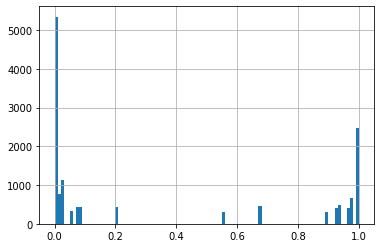

In [18]:
# visualize predictions
prediction.hist(bins=100);

## Monitoring a classification


### Option a) monitor the share of positive predictions with an uppper and lower bound


#### Step 1: Understand how stable your predictions are
During evaluation, you typically treat the evaluation set as one big set. During inference however the data comes in in order and might fluctuate, e.g. with a daily or with a weekly pattern. You need to know if your predictions are typically stable over time.

In [19]:
import matplotlib.pyplot as plt
# you decided that you get the best precision-recall tradeoff for 
# your problem at 0.8 (making it up here, not actually based on the dataset)
your_threshold=0.8


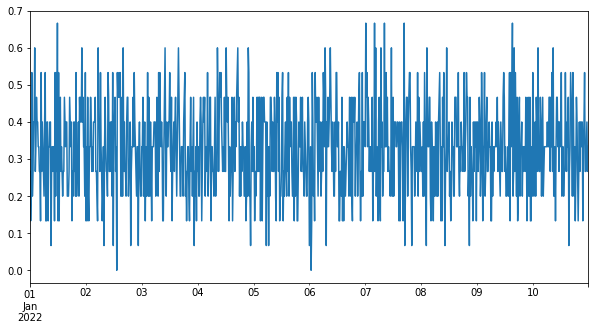

In [20]:
# real-time prediction with a small time range (as small as you can get away with considering your amount of traffic)
(prediction>your_threshold).resample("15min").mean().plot(figsize=(10,5));
# this looks very noisy! if you have that little traffic (1 req/min), you can only alert with broad thresholds
# e.g. rejection ==0 or rejection >0.7
# Go ahead and create this alert. Sometimes catastrophic failure happens and it is good to have a fast alert,
# even if it only uncovers big problems                          

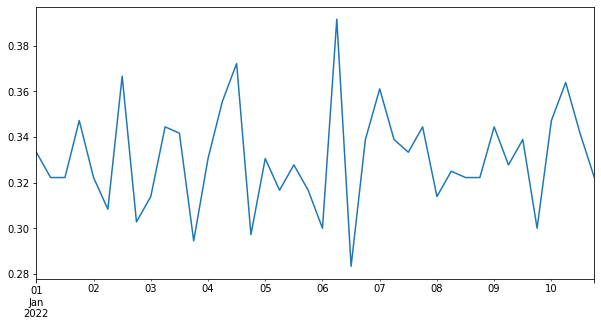

In [22]:
(prediction>your_threshold).resample("6H").mean().plot(figsize=(10,5));
#-> here you see that the share of positive predictions fluctuates between 0.28 and 0.38 
# you could alert if the share is below 0.28 or above .40 or 0.25 and .42

### Option b) Use a statistical test
If you alert on the whole distribution, you get more fine grained information. On the other hand, you mostly care
about the customer experience changing, so I personally prefer option a) 

In [8]:
# TODO: implement google d1 metrics 